[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/regression/polynomial_regression.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# Polynomial Regression

This notebook shows an example of polynomial linear regression using Stochastic Gradient Descent.

We use a modification of the [Housing Prices Dataset](https://www.kaggle.com/datasets/yasserh/housing-prices-dataset) stored in `data/housing.csv`. The dataset contains the following columns:
- price (dependent variable or target): Price of the house (in USD).
- width: Width of the house (in square feet).
- length: Length of the house (in square feet).
- bedrooms: Number of bedrooms.
- bathrooms: Number of bathrooms.
- stories: Number of stories.
- mainroad: Whether the house is near a main road (yes or no).
- guestroom: Whether the house has a guest room (yes or no).
- basement: Whether the house has a basement (yes or no).
- hotwaterheating: Whether the house has hot water heating (yes or no).
- airconditioning: Whether the house has air conditioning (yes or no).
- parking: Number of parking spots.
- prefarea: Whether the house is in a preferred area (yes or no).
- furnishingstatus: Furnishing status of the house (furnished, semi-furnished, unfurnished).
- quality: An integer value representing the quality of the house.

In [21]:
# make sure the required packages are installed
%pip install numpy pandas scikit-learn matplotlib seaborn --quiet

# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/regression'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.

# import the required modules
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import pandas as pd
import numpy as np

import utils

pd.set_option('display.max_columns', None)  # Display all columns of a DataFrame in pandas
random_state = 42

Note: you may need to restart the kernel to use updated packages.


## Data preparation

We load the dataset from the file, split in train and test sets, and visualize the distribution of the variable values. Then, we handle outliers and missing values, and we transform the variable types to be able to use them in the model.

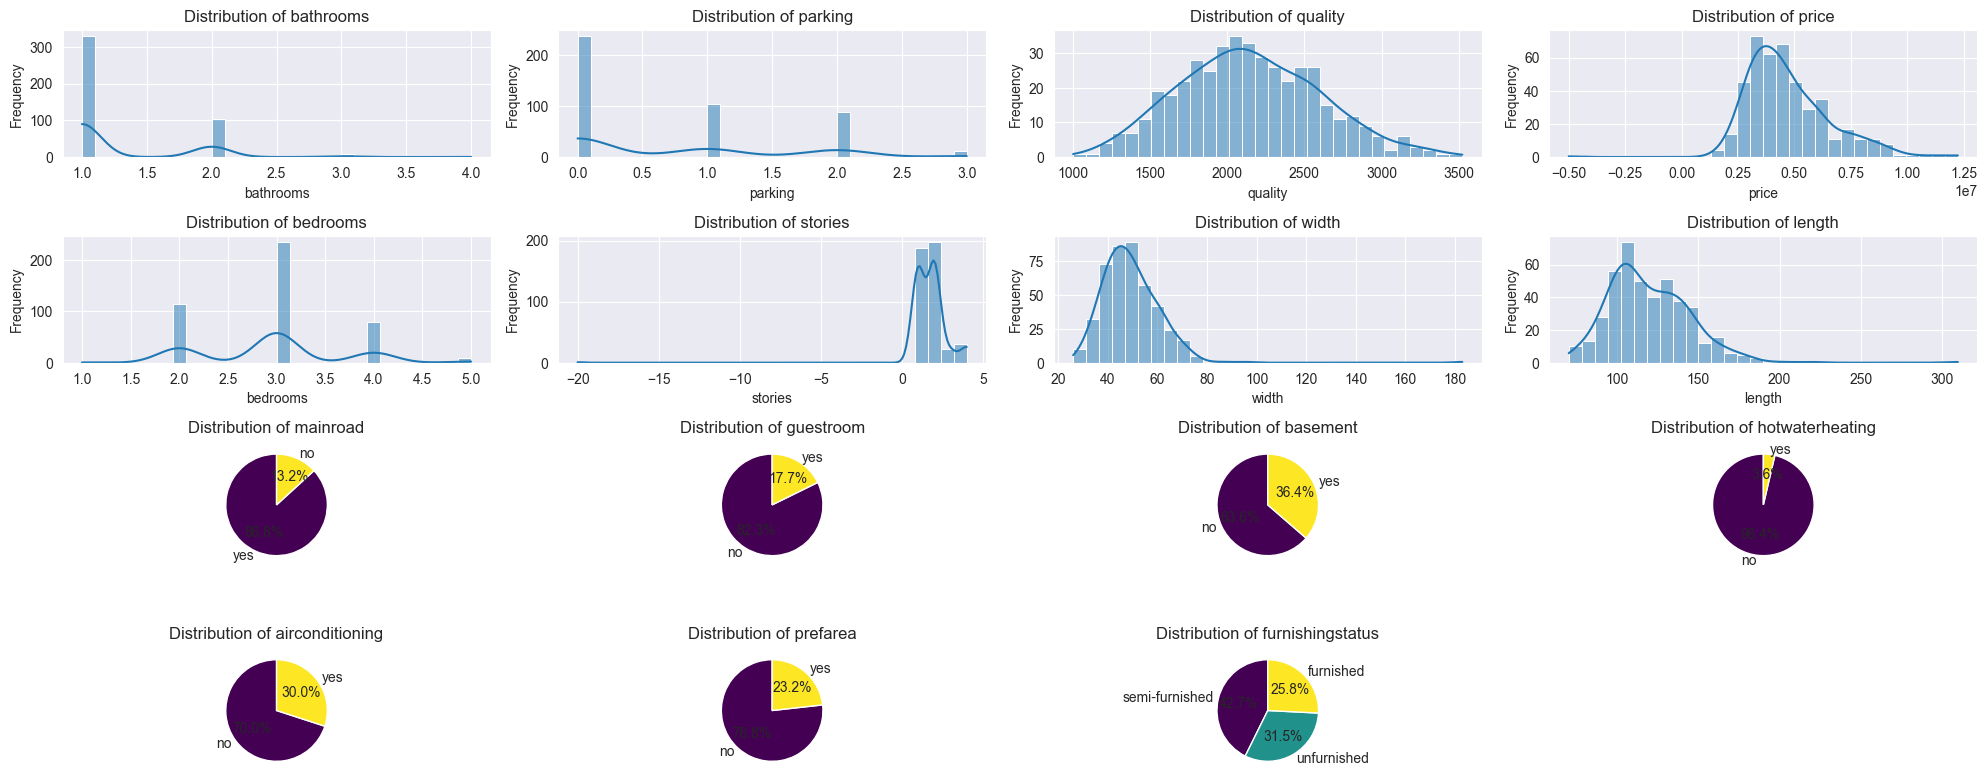

In [22]:
dataset_file_name = 'data/housing.csv'
integer_independent_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
binary_independent_vars = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
nominal_independent_vars = ['furnishingstatus']
independent_vars = integer_independent_vars + binary_independent_vars + nominal_independent_vars
dependent_var = 'price'

# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = utils.load_dataset_from_csv(dataset_file_name, independent_vars,
                                                                   dependent_var, 0.2, random_state)
# Concatenate X_train and y_train in train_dataset to visualize all the variables, including the target
train_dataset = pd.concat([X_train, y_train], axis=1)
# Visualize the distribution of the dataset
utils.plot_feature_value_distribution(train_dataset)

We can also visually analyze the correlation between the non-nominal variables in the dataset using a pairplot. It creates a matrix of scatter plots for each pair of variables in the dataset, allowing us to see the relationships between them. In the diagonal, it shows the distribution of each variable using histograms. *Remember*: it only shows non-nominal variables.

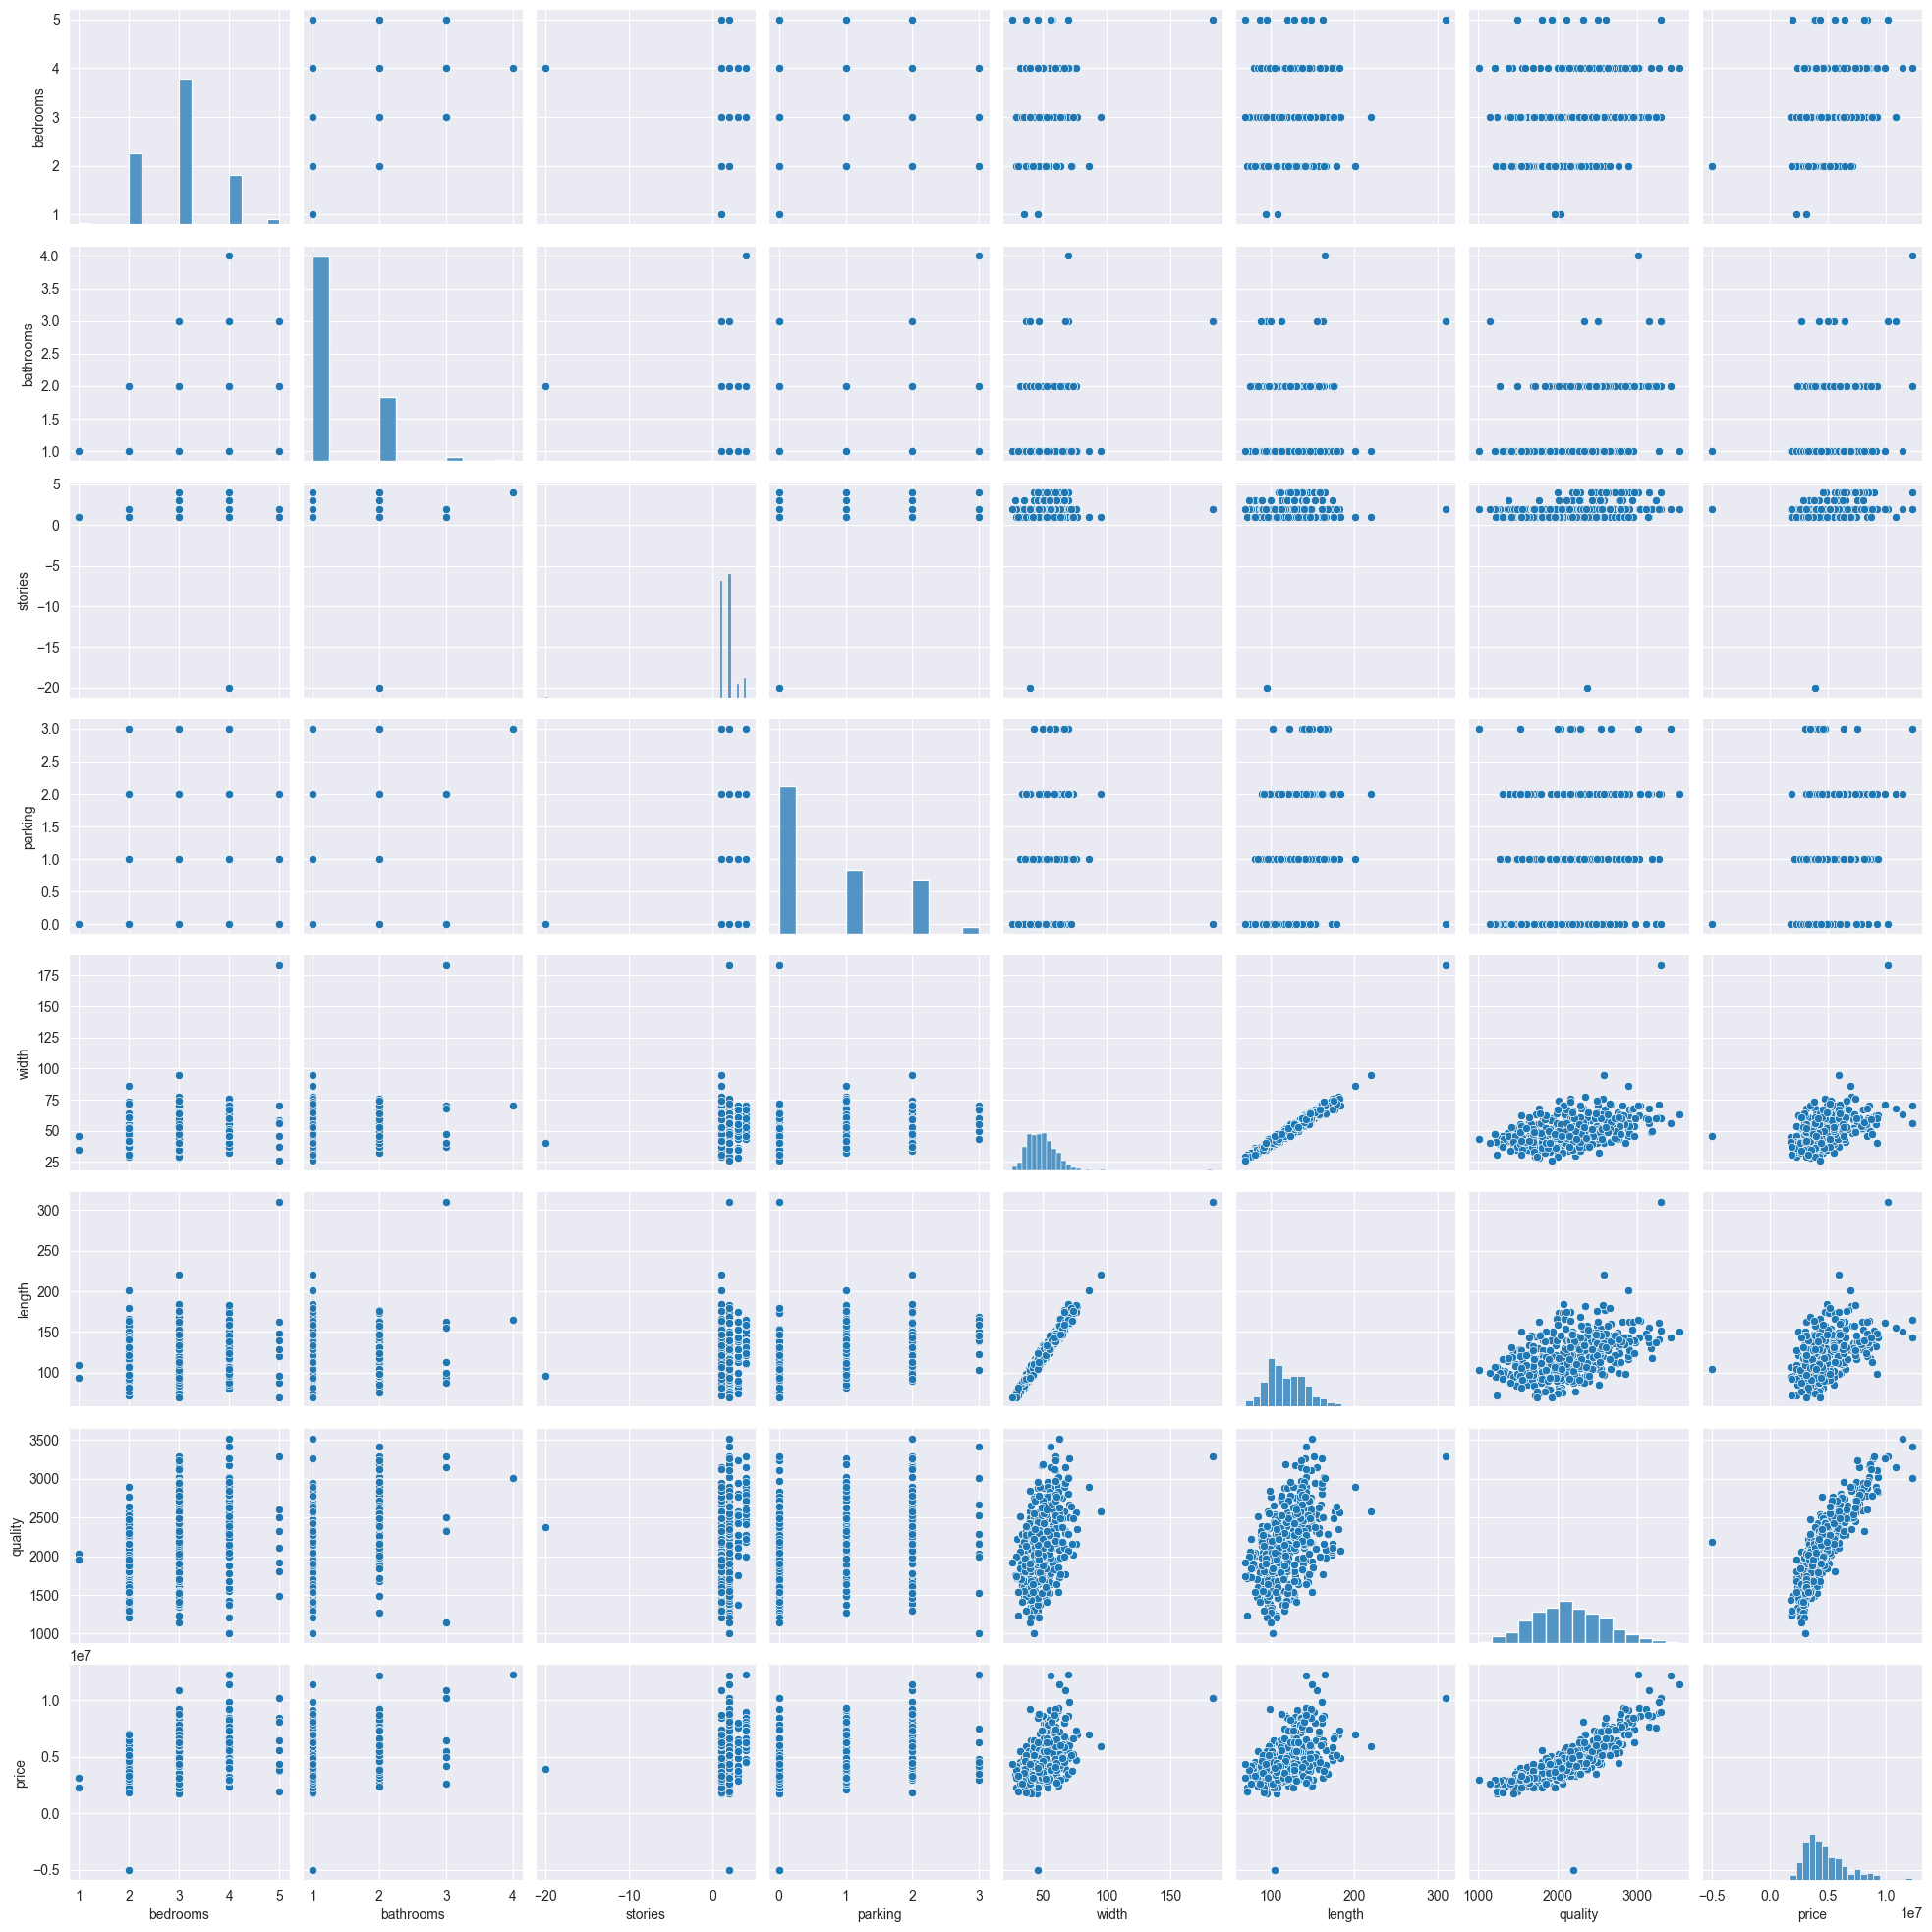

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(train_dataset)
plt.show()

In the above visualization, we can see different interesting information:
1. Some independent variables have a non-linear relationship with the target variable `price` (e.g., `quality`).
2. Some independent variables are correlated (e.g., `width` and `length`). This may cause multicollinearity problems in linear regression models.
3. The `quality` independent variable has a symmetric and unimodal distribution.
4. The `price`, `width`, and `length` independent variables seem to have outliers causing a long tail in the distribution and not being symmetric.

### Outliers

We detect the outliers in the `quality` numerical feature using the IQR Tukey’s Fences rule. In the visualization, we saw `quality` it is a symmetric and unimodal (one single peek value) variable, so the requirements to apply Tukey's fences are met.

In [24]:
tukeys_features = ['quality']
# outliers_df holds True for outlier and False for inlier
tukey_outliers_df = utils.detect_outliers_iqr(train_dataset[tukeys_features], threshold=1.5) # 1.5 = mild outliers, 3.0 = extreme outliers
# We take the train dataset, filter the tukey's features apply the outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
tukey_outliers = train_dataset[tukeys_features][tukey_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print(f"Number of outliers in the training set using Tukey's Fences rule: {(n_outliers_tukey := tukey_outliers.shape[0])}.")
if n_outliers_tukey > 0:
    print("Values of the outliers in the training set:\n", tukey_outliers, end='\n\n')

Number of outliers in the training set using Tukey's Fences rule: 1.
Values of the outliers in the training set:
    quality
4   3521.0



The numeric variables `length` and `width` do not meet the requirements of the Tukey's Fences rule. However, they are unimodal and not highly asymmetric, so we can apply the modified Z-score method to detect outliers. These conditions are also met by the `bedrooms` and `stories` variables. Thus, we apply the modified Z-score method to them.

In [25]:
modified_z_features = ['length', 'width', 'bedrooms', 'stories']
# outliers_df holds True for outlier and False for inlier
modified_z_outliers_df = utils.detect_outliers_modified_z(train_dataset[modified_z_features], threshold=3.5)
# We take the train dataset, filter the modified z-score features apply the modified_z_outliers_df mask to get the outliers
# If True (outlier), the outliers variable holds the outlier value; otherwise, it holds NaN 
modified_z_outliers = train_dataset[modified_z_features][modified_z_outliers_df]  \
    .dropna(how='all')  # Drop rows with all NaN values (no outlier in the row)
print(f"Number of outliers in the training set using Modified Z-score method: {(n_outliers_modified_z := modified_z_outliers.shape[0])}.")
if n_outliers_modified_z > 0:
    print("Values of the outliers in the training set using the Modified Z-score method:\n", modified_z_outliers, end='\n\n')

Number of outliers in the training set using Modified Z-score method: 4.
Values of the outliers in the training set using the Modified Z-score method:
      length  width  bedrooms  stories
7     310.0  183.0       NaN      NaN
344     NaN    NaN       NaN    -20.0
130   220.0   95.0       NaN      NaN
71    201.0   86.0       NaN      NaN



This is a summary of the outliers found:
- The `quality` variable has one outlier (Tukey's fences). It does not seem to be erroneous data, so we can scale their values to lessen the impact of their values ([`RobustScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html) is less sensitive to outliers than `StandardScaler` because it uses the median and IQR instead of mean and standard deviation). If data is normal with no outliers, `StandardScaler` is a better choice.
- The `stories` variable holds one outliers (Modified Z-score). It is an error because there are no houses with 0 or less stories. We will set it to NaN and treat it as a missing value.
- The `width` and `length` of three samples are outliers (Modified Z-score). It does not seem to be erroneous data (they represent houses build on a big area), so we can scale their values to lessen the impact of their values (using `RobustScaler`).


In [42]:
# Set the negative values to NaN in the `stories`, `bathrooms` and `bedrooms` column
non_negative_vars = ['bedrooms', 'bathrooms', 'stories', 'parking', 'width', 'length', 'quality']
utils.modify_cells_lower_than(X_train, column_names=non_negative_vars, cell_value=np.nan, threshold=0)
utils.modify_cells_lower_than(X_test, column_names=non_negative_vars, cell_value=np.nan, threshold=0)
for non_negative_var in non_negative_vars:
    print(f"Number of values with '{non_negative_var}' < 0 in the training set: {X_train['stories'][X_train['stories'] < 0].count()}.",)
    print(f"Number of values with '{non_negative_var}' < 0 in the test set: {X_test['stories'][X_test['stories'] < 0].count()}.",)
# Remove the samples with negative values for the target variable (`price`) from both train and test datasets since we cannot deal with errors (impute) in the target variable.
y_train, X_train = utils.drop_rows_lower_than(y_train, X_train, threshold=0)
y_test, X_test = utils.drop_rows_lower_than(y_test, X_test, threshold=0)
print(f"Number of values with 'price' < 0 in the training set: {y_train[y_train < 0].count()}.")
print(f"Number of values with 'price' < 0 in the test set: {y_test[y_test < 0].count()}.")

Number of values with 'bedrooms' < 0 in the training set: 0.
Number of values with 'bedrooms' < 0 in the test set: 0.
Number of values with 'bathrooms' < 0 in the training set: 0.
Number of values with 'bathrooms' < 0 in the test set: 0.
Number of values with 'stories' < 0 in the training set: 0.
Number of values with 'stories' < 0 in the test set: 0.
Number of values with 'parking' < 0 in the training set: 0.
Number of values with 'parking' < 0 in the test set: 0.
Number of values with 'width' < 0 in the training set: 0.
Number of values with 'width' < 0 in the test set: 0.
Number of values with 'length' < 0 in the training set: 0.
Number of values with 'length' < 0 in the test set: 0.
Number of values with 'quality' < 0 in the training set: 0.
Number of values with 'quality' < 0 in the test set: 0.
Number of values with 'price' < 0 in the training set: 0.
Number of values with 'price' < 0 in the test set: 0.


### Missing values

First, we detect the missing values in the dataset. Then, we analyze the results and treat the missing values.

In [27]:
# We print the instances that have any missing values
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the train dataset:
      bedrooms  bathrooms  stories  parking  width  length  quality mainroad  \
56        4.0          2      2.0        1   62.0   143.0     3026      NaN   
57        4.0          2      4.0        2   60.0   138.0     2679      yes   
59        3.0          1      NaN        1    NaN   133.0     2498      yes   
344       4.0          2      NaN        0   40.0    96.0     2371      yes   
58        3.0          1      1.0        1    NaN     NaN     2841      yes   

    guestroom basement hotwaterheating airconditioning prefarea  \
56         no       no              no             yes      yes   
57         no       no              no              no       no   
59         no       no             NaN             yes      NaN   
344        no       no              no              no       no   
58         no      yes              no             yes      yes   

    furnishingstatus  
56    semi-furnished  
57               NaN  
59             

There are missing values in the dataset. We will treat them using the same criteria in train and test sets. First, if there are 3 or more missing values in a sample, we will remove the whole sample.  **Important**: We should remove the corresponding rows in the target variable as well.

In [28]:
X_train, y_train = utils.drop_rows_multiple_missing_values(X_train, y_train, threshold=3)
X_test, y_test = utils.drop_rows_multiple_missing_values(X_test, y_test, threshold=3)

For the rest of the missing values, we will impute the missing values using simple univariate imputation methods: 
- For the integer variables, we will use the median value (mean would produce double values and it is more sensitive to outliers).
- For the binary and nominal variables, we will use the most frequent value (mode).

Let's start by replacing the missing values in the dataset with the median value of the column.

In [29]:
integer_imputer = SimpleImputer(strategy='median')
X_train[integer_independent_vars] = integer_imputer.fit_transform(X_train[integer_independent_vars])
X_test[integer_independent_vars] = integer_imputer.transform(X_test[integer_independent_vars])

Now, for the binary and nominal variables, we will use the most frequent value (mode).

In [30]:
binary_nominal_imputer = SimpleImputer(strategy='most_frequent')
binary_nominal_features = binary_independent_vars + nominal_independent_vars
X_train[binary_nominal_features] = binary_nominal_imputer.fit_transform(X_train[binary_nominal_features])
X_test[binary_nominal_features] = binary_nominal_imputer.transform(X_test[binary_nominal_features])
# Now, there are no missing values in the dataset
print("Missing values in the training and test sets after handling missing values.")
utils.show_missing_values(X_train, 'train')
utils.show_missing_values(X_test, 'test')

Missing values in the training and test sets after handling missing values.
Missing values in the train dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus]
Index: []

Missing values in the test dataset:
 Empty DataFrame
Columns: [bedrooms, bathrooms, stories, parking, width, length, quality, mainroad, guestroom, basement, hotwaterheating, airconditioning, prefarea, furnishingstatus]
Index: []



### Set the valid types for the variables

Nominal variables should be converted into numbers so that the model can understand them. First, we deal with binary variables, changing "yes" and "no" values to 1 and 0, respectively.

In [31]:
for feature_name in binary_independent_vars:
    X_train[feature_name] = X_train[feature_name].map({'yes': 1, 'no': 0})
    X_test[feature_name] = X_test[feature_name].map({'yes': 1, 'no': 0})

`furnishingstatus` cannot be converted into an ordinal integer value (label encoding) because it represents no order. Therefore, we use one-hot encoding to transform it into a format that the model can understand.

In [32]:
for feature_name in nominal_independent_vars:
    X_train = (pd.get_dummies(X_train, columns=[feature_name])
               .astype(int))  # sets it to 0 or 1 instead of True or False
    X_test = pd.get_dummies(X_test, columns=[feature_name]).astype(int)

We have finished the data preparation. We finally visualize the influence of the features on the target variable and store the curated dataset in a single csv file.

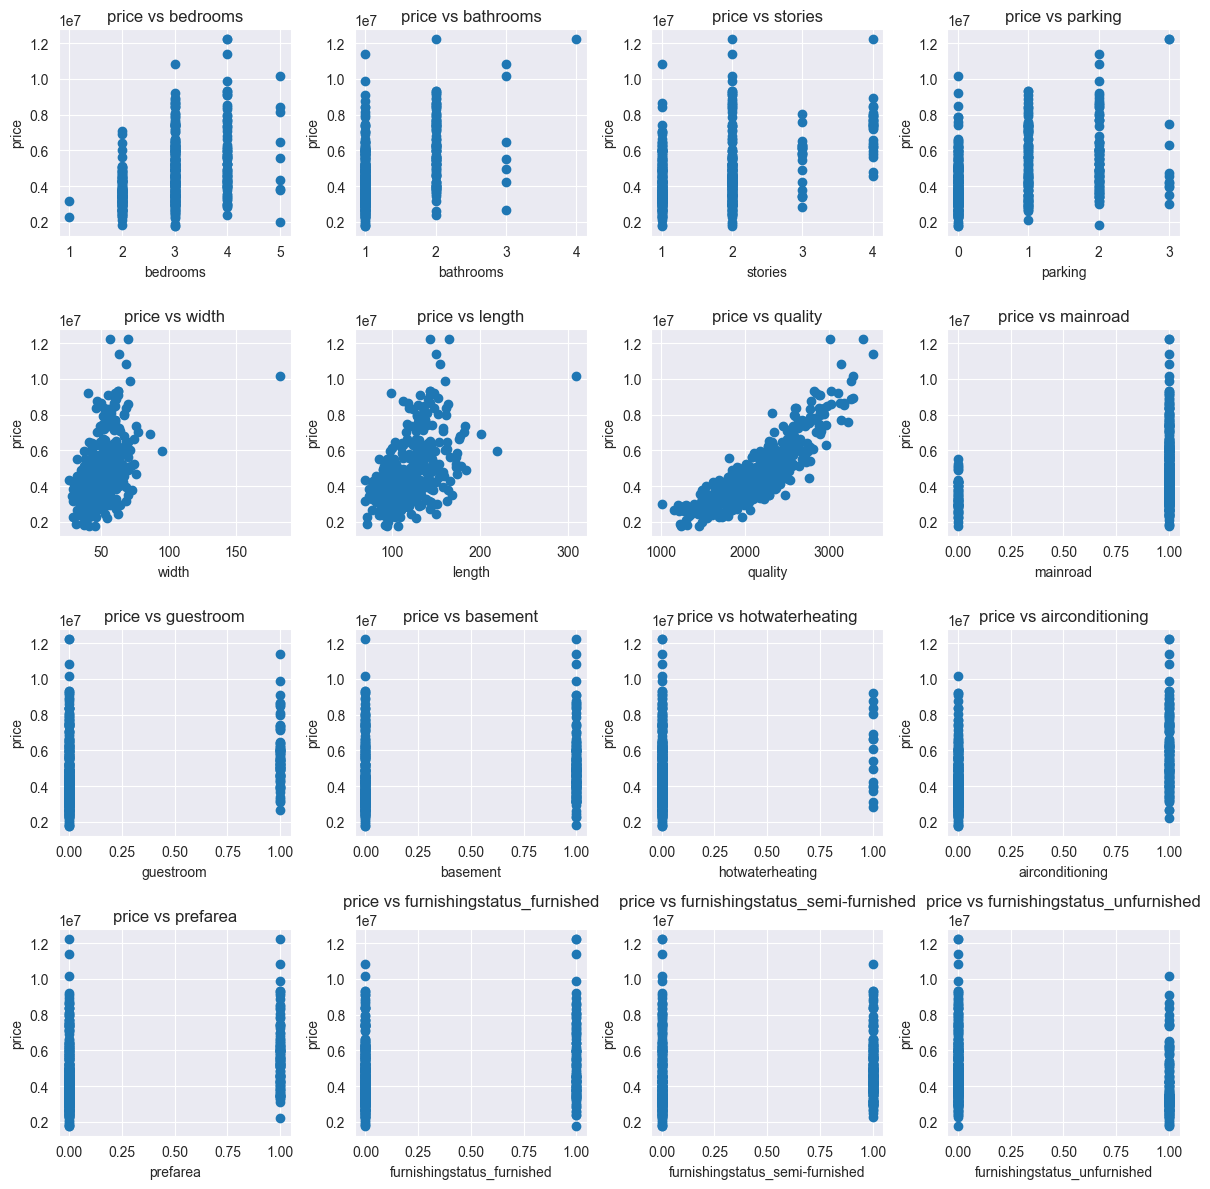

In [33]:
# Visualize the influence of the features on the target variable
utils.visualize_influence(X_train, y_train)
# Store the curated X_train, X_test, y_train and y_text merged in a single csv file
utils.store_dataset(X_train, y_train, X_test, y_test, 'data/housing_curated.csv')

## Model creation, training, and evaluation

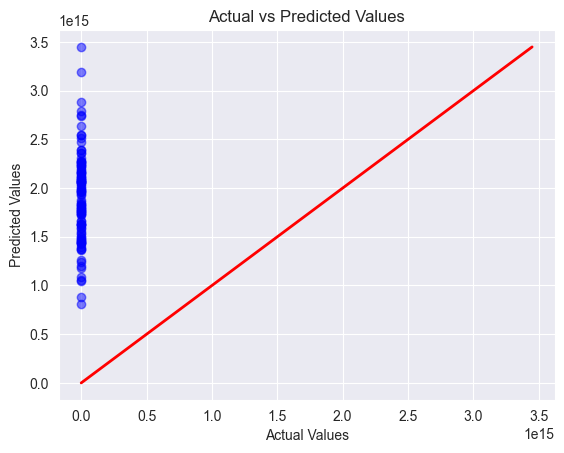

Mean Squared Error (MSE): 3842188929511577203764210171904.0000
Root Mean Squared Error (RMSE): 1960150231362784.5000
Mean Absolute Error (MAE): 1905717934854104.0000
R-squared determination coefficient: -822812684590488064.0000



In [34]:
metrics= utils.create_SDG_regression_model_and_evaluate(X_train, y_train, X_test, y_test, random_state)
utils.show_regression_performance(*metrics)

## ✨ Activity 1 ✨

The previous model does not perform well. After reading all the previous code, there is something we should have done, and we have not done. Can you identify what it is? Do it and check if the model has increased its performance. 

In [35]:
# Write your code here.

 

## ✨ Activity 2 ✨

Does it occur to you to perform any *feature engineering* to improve the model? Do one step after another and check if the model has increased its performance.

In [36]:
# Write your code here.

 